In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import localtime, strftime
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import torch.optim as optim
import sklearn.preprocessing as preprocess
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import covariance as cov
import pandas as pd
from pdb import set_trace as bp
%matplotlib inline

In [2]:
from skorch import NeuralNetClassifier
# from skorch.classifier import NeuralNetBinaryClassifier, CVSplit
from skorch.callbacks import EpochScoring

In [3]:
data_dir = '/media/l7/data_storage1/datasets/afib_dataset/training2017/'

## Main Points: 
* Feature Engineering
* Deep Learning (CNN)
* Class imbalance
* PyTorch
* Scorch
* SKLearn


## Basic Functions

In order to begin the feature engineering, we need to first define some of the custom functions which are necessary to work with the dataset. In this case, we have the function that produces the fft features, and the target mapping function.

In [6]:

def get_fft(data, absolute_value=True):
    """
    Compute the fft for a specific input dataset.
    :param data:
    :param absolute_value:
    :return:
    """
    fft_data = np.fft.fft(data, axis=1) * 1/data.shape[1]
    if not absolute_value:
        return fft_data
    else:
        abs_fft_data = abs(fft_data[:,:int(fft_data.shape[1] / 2)])
        return abs_fft_data


def label_mapping(label):
    if label == 'N':
        return 0
    elif label =='A':
        return 1
    elif label =='O': 
        return 2
    else: 
        return 3


## Load the Data

In the case of this tutorial, the data has already been pre-processed and formatted to the desired types and dimensions. Part of the pre-processing included parsing the raw waveforms to a zero padded numpy array, thereby providing a uniform size input matrix for the machine learning experiments. 

In [7]:
data_np = np.load(data_dir + 'data_np.npy')
labels_np = np.load(data_dir + 'labels.npy')
data_np

array([[-0.127, -0.162, -0.197, ...,  0.   ,  0.   ,  0.   ],
       [ 0.128,  0.157,  0.189, ...,  0.   ,  0.   ,  0.   ],
       [ 0.056,  0.073,  0.085, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [-0.202, -0.235, -0.272, ...,  0.   ,  0.   ,  0.   ],
       [-0.227, -0.297, -0.374, ...,  0.   ,  0.   ,  0.   ],
       [-0.237, -0.286, -0.338, ...,  0.   ,  0.   ,  0.   ]])

In [8]:
validation_data_np = np.load(data_dir + 'validation_data_np.npy')
validation_labels_np = np.load(data_dir + 'validation_labels.npy')
validation_data_np

array([[-0.127, -0.162, -0.197, ...,  0.   ,  0.   ,  0.   ],
       [ 0.128,  0.157,  0.189, ...,  0.   ,  0.   ,  0.   ],
       [ 0.056,  0.073,  0.085, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.565,  0.676,  0.783, ...,  0.   ,  0.   ,  0.   ],
       [-0.039, -0.06 , -0.077, ...,  0.   ,  0.   ,  0.   ],
       [-0.268, -0.325, -0.383, ...,  0.   ,  0.   ,  0.   ]])

## Establish Sample Size

By definition, we can classify whether or not a signal is Afib with 30 seconds of information. Therefore, in order to make our input dimensions smaller, let's make sure that we have at most 30 seconds worth of information. Based on the sampling frequency, this means that we will have at most 9000 samples in the input dimension. 

In [9]:
sample_size = 9000

## Scale Data for Processing


In [10]:
?preprocess.StandardScaler

In [11]:
standard_scaler = preprocess.StandardScaler()
standard_scaler.fit(data_np[:,:sample_size])
processed_data = standard_scaler.transform(data_np[:,:sample_size])

In [10]:
standard_scaler = preprocess.StandardScaler()
standard_scaler.fit(validation_data_np[:,:sample_size])
validation_processed_data = standard_scaler.transform(validation_data_np[:,:sample_size])

## Add Helper Functions

Below we add a couple of helper functions to aid in the class balancing and data augmentation.

In [12]:
def add_noise_to_dataset(data, numpy_data=False, 
                         noise_distribution=None, std=1.0):
    """
    This function adds noise to data array. Noise is added for some specific distribution, with a set
    standard deviation.
    :param data: numpy array
    :param numpy_data: bool, describing whether or not the data is a numpy array (otherwise it will be torch tensor)
    :param noise_distribution:
    :param std:
    :return: numpy array with added noise
    """
    numpy_tensor = False
    pytorch_tensor = False
    if not numpy_data:
        if 'numpy' in str(type(data)):
            numpy_tensor = True
            data = torch.tensor(data).float()
        else:
            pytorch_tensor = True

    if not noise_distribution:
        if numpy_data:
            noise_distribution = np.random.randn(data.shape[0], 
                                                 data.shape[1])
            data = data + noise_distribution
        else:
            noise_distribution = np.random.randn(data.shape[0],
                                                 data.shape[1],
                                                 data.shape[2])
            data = data + torch.tensor(noise_distribution).float().to(data.device)

    else:
        if numpy_data:
            data = data + noise_distribution(scale=std,
                                             size=[data.shape[0], 
                                                   data.shape[1]])
        else:
            data = data + torch.tensor(
                noise_distribution(scale=std, 
                                   size=[data.shape[0], 
                                         data.shape[1], 
                                         data.shape[2]])).float().to(data.device)
    if pytorch_tensor:
        return data
    elif numpy_data:
        return data
    else:
        return data.numpy()

In [13]:
def double_class_rows(dataset, labels, class_number=1, 
                      random_state=1,
                     add_noise=False, noise_distribution=None,
                      std=1.0):
    """
    This function helps balance by adding (or cloning) observations of a specific type.
    :param dataset:
    :param labels:
    :param class_number:
    :param random_state:
    :return:
    """
#     bp()
    sample_rows = np.where(labels == class_number)
    if add_noise:
        dataset_new = add_noise_to_dataset(dataset[sample_rows],
                                numpy_data=True, 
                                noise_distribution=noise_distribution, 
                                std=std)
    else:
        dataset_new = dataset[sample_rows]
    dataset = np.concatenate((dataset, dataset_new))
    labels = np.concatenate((labels, labels[sample_rows]))
    dataset, x_test, labels, y_test = train_test_split(dataset,
                                                      labels,
                                                      test_size=0,
                                                      random_state=random_state)
    print(dataset.shape)
    return dataset, labels
    

Additionally, we also define the funciton which will print out the classification results in a format that is more readable. 

In [14]:
classes = ['N', 'A', 'O', '~']
def plot_confusion_matrix(y_pred, y, prefix_information='',
                          dataset_name='', save_results=False,
                          y_pred_is_predicted_classes=False):
    """
    PLotting confusion matrix of different datasets (train, test, and validation).
    :param y_pred:
    :param y:
    :param prefix_information:
    :param dataset_name:
    :param save_results:
    :param y_pred_is_predicted_classes:
    :return:
    """
    if 'Tensor' in str(type(y)):
        y = y.numpy()
    c_matrix = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    result_accuracy_string = "Accuracy of Net: {:.2f}".format(accuracy)
    print(result_accuracy_string)
    print("\nClassification report:")
    classfication_report_string = classification_report(y, y_pred)
    print(classfication_report_string)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    #ax.set_title(dataset_name + " Confusion matrix")
    ax.set_title(" Confusion matrix", fontsize=24)
    sns.heatmap(c_matrix, cmap='Blues', 
                annot=True, xticklabels=classes, 
                yticklabels=classes, fmt='g', cbar=False)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xlabel('predictions', fontsize=22)
    ax.set_ylabel('true labels', fontsize=22)
    plt.tick_params(labelsize=18)
    plt.tight_layout()
    # plt.show()
    return accuracy
    

## Define the Machine Learning Model

In this tutorial, the emphasis is on the Feature Engineering. As such, the model chosen as a LeNet5 CNN model, whose performance and structure has been well studied and defined. 

The definition below provides a model that is able to change based on the input dimension, for hyper-parameter optimization and inputs of different dimensions. Note that None of the layers or kernel dimensions have a static value. 

In [15]:
class LeNet5(nn.Module):
    def __init__(self, n_channels, n_features, mid_layer_channels=10,
                 C_k_p_s_1=[5, 0, 1], M_k_s_1=[2, 2], C_k_p_s_2=[5, 0, 1],
                 M_k_s_2=[2, 2], p=[0.0, 0.0, 0.0, 0.0, 0.0]):
        """
        Replica of a LeNet5 model, with adaptable parameters
        :param n_channels: number of channels in the input data
        :param n_features: number of features in the input data
        :param mid_layer_channels: number of layers which will be produced by the 
        the middle CNN layer
        :param C_k_p_s_1: list containing kernel_size, padding, and stride
        :param C_k_p_s_2: list containing kernel_size, padding, and stride 
        :param M_k_s_1: list containing max pooling kernel_size and stride
        :param M_k_s_2: list containing max pooling kernel_size and stride
        :param p: dropout layer probabilities
        """
        super(LeNet5, self).__init__()
        self.name = 'LetNet5'
        self.conv1d_1 = nn.Conv1d(n_channels, mid_layer_channels,
                                  kernel_size=C_k_p_s_1[0], padding=C_k_p_s_1[1],
                                  stride=C_k_p_s_1[2])
        self.relu = nn.ReLU()
        self.max_pool_1 = nn.MaxPool1d(kernel_size=M_k_s_1[0],
                                       stride=M_k_s_1[1])
        current_input_size = \
        (1 + (n_features - C_k_p_s_1[0]\
              + 2 * C_k_p_s_1[1]) / C_k_p_s_1[2]) / M_k_s_1[0]
        current_input_size = int(current_input_size)
        self.drop_out_1 = nn.Dropout(p=p[0])
#         bp()
        self.conv1d_2 = nn.Conv1d(mid_layer_channels,
                                  2 * mid_layer_channels, 
                                  kernel_size=C_k_p_s_2[0],
                                  padding=C_k_p_s_2[1],
                                  stride=C_k_p_s_2[2])
        current_input_size = \
        (1 + (current_input_size - C_k_p_s_2[0]\
              + 2 * C_k_p_s_2[1]) / C_k_p_s_2[2]) / M_k_s_1[0]
        current_input_size = int(current_input_size)
        self.drop_out_2 = nn.Dropout(p=p[1])
#         bp()
        self.max_pool_2 = nn.MaxPool1d(kernel_size=M_k_s_2[0],
                                       stride=M_k_s_2[1])
#         bp()
        self.fc1 = nn.Linear(2 * mid_layer_channels * current_input_size, 120)
        self.drop_out_3 = nn.Dropout(p=p[2])
        self.fc2 = nn.Linear(120, 84)
        self.drop_out_4 = nn.Dropout(p=p[3])
        self.fc3 = nn.Linear(84, 10)
        self.drop_out_5 = nn.Dropout(p=p[4])
        self.soft_max = nn.Softmax(dim=1)
        self.fc4 = nn.Linear(10, 4)
        
    def forward(self, x):
#         bp()
        x = x.float()
        x = self.max_pool_1(self.relu(self.drop_out_1(self.conv1d_1(x))))
        # bp()
        x = self.max_pool_2(self.relu(self.drop_out_2(self.conv1d_2(x))))
        x = x.view(x.shape[0], x.shape[1] * x.shape[2])
        x = self.relu(self.drop_out_3(self.fc1(x)))
        x = self.relu(self.drop_out_4(self.fc2(x)))
        x = self.relu(self.drop_out_5(self.fc3(x)))
        x = self.fc4(x)
        x = self.soft_max(x)
        return x


In addition to the model, we must also build on Skorch, to facilitate training. For this purpose we define a custom train_model(.) function which helps with the training. 

In [16]:
def train_model(n_features, n_channels, x_train, y_train,
               device = torch.device('cuda'), model_name = LeNet5.__name__,
               model = None, n_epochs = 10):
    if model is None:
        model = NeuralNetClassifier(module=LeNet5, 
                                    criterion=nn.CrossEntropyLoss,
                                    module__n_channels= n_channels,
                                    module__n_features=n_features,
                                    optimizer=optim.Adam, 
                                    optimizer__lr=0.001,
                                    max_epochs=n_epochs, 
                                    batch_size=32,
                                    iterator_train__shuffle=True,
                                    device=device,
                                    warm_start=True,
                                   )
    model.fit(x_train, y_train, epochs=n_epochs)
    pred_train = model.predict(x_train)
    accuracy = plot_confusion_matrix(pred_train, y_train, )
    return model, pred_train, accuracy
    

In [18]:
train_data = processed_data
#test_data = validation_processed_data
labels_train = labels_np


In [17]:
labels_test = validation_labels_np

Below we verify the class distribution in order to consider augmentation and class balancing

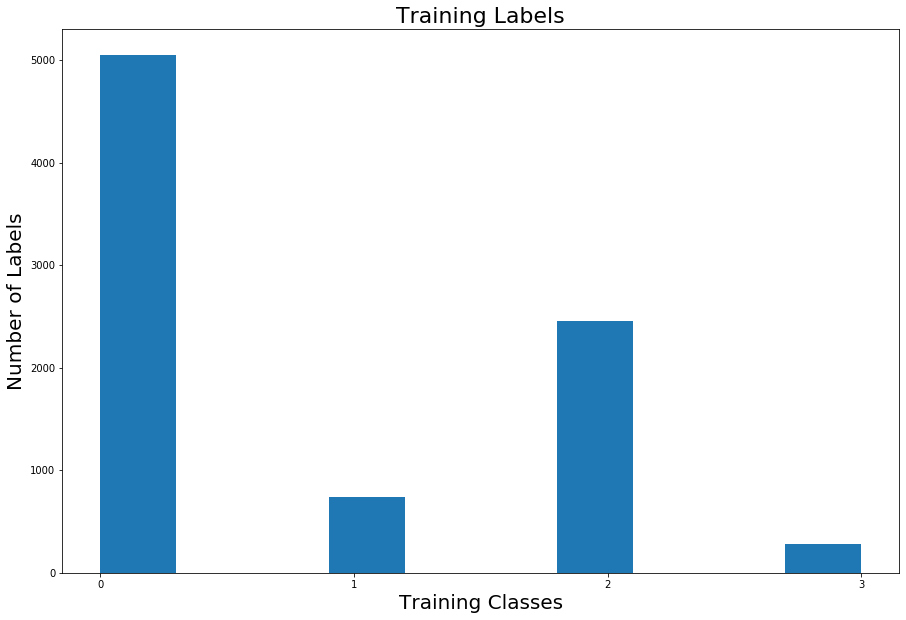

In [19]:
plt.figure(figsize=(15,10))
plt.hist(labels_train)
plt.title('Training Labels', fontsize=22)
plt.xlabel('Training Classes', fontsize=20)
plt.xticks([0, 1, 2, 3])
plt.ylabel('Number of Labels', fontsize=20)
plt.show()

In [20]:
train_data, labels_train = double_class_rows(train_data, labels_np, class_number=1, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=3, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.3)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=3, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=1, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)

(9266, 9000)
(9550, 9000)
(10118, 9000)
(11594, 9000)


In [21]:
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=3, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=3, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.3)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=2, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=1, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)

(12730, 9000)
(15002, 9000)
(17458, 9000)
(20410, 9000)


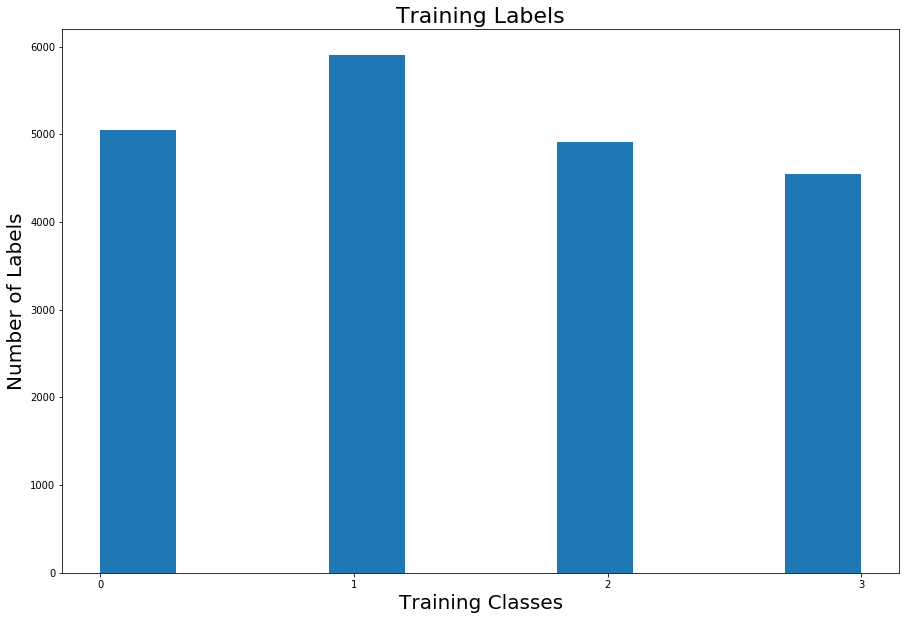

In [22]:
plt.figure(figsize=(15,10))
plt.hist(labels_train)
plt.title('Training Labels', fontsize=22)
plt.xlabel('Training Classes', fontsize=20)
plt.xticks([0, 1, 2, 3])
plt.ylabel('Number of Labels', fontsize=20)
plt.show()

## Let's Evaluate the Raw Dataset

Before we get to the Feature Engineering, let's see how the dataset performs without the dimensionality reduction, or feature engineering. 

In [23]:
sample_size = 9000

In [24]:
x_train = torch.tensor(processed_data[:,:sample_size]).float().unsqueeze(1)
y_train = torch.tensor(labels_np).long()
x_train.shape

torch.Size([8528, 1, 9000])

In [26]:
y_train.shape

torch.Size([8528])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1531       0.5917        1.1520  3.0741
      2        1.1514       0.5917        1.1520  2.3964
      3        1.1514       0.5917        1.1520  2.4132
      4        1.1514       0.5917        1.1520  2.4550
      5        1.1514       0.5917        1.1520  2.4079
      6        1.1514       0.5917        1.1520  2.4137
      7        1.1514       0.5917        1.1520  2.4125
      8        1.1514       0.5917        1.1520  2.4146
      9        1.1514       0.5917        1.1520  2.4105
     10        1.1514       0.5917        1.1520  2.4080
     11        1.1514       0.5917        1.1520  2.4427
     12        1.1514       0.5917        1.1520  2.4811
     13        1.1514       0.5917        1.1520  2.4162
     14        1.1514       0.5917        1.1520  2.4151
     15        1.1514       0.5917        1.1520  2.4153
     16        1.1514       0.5

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


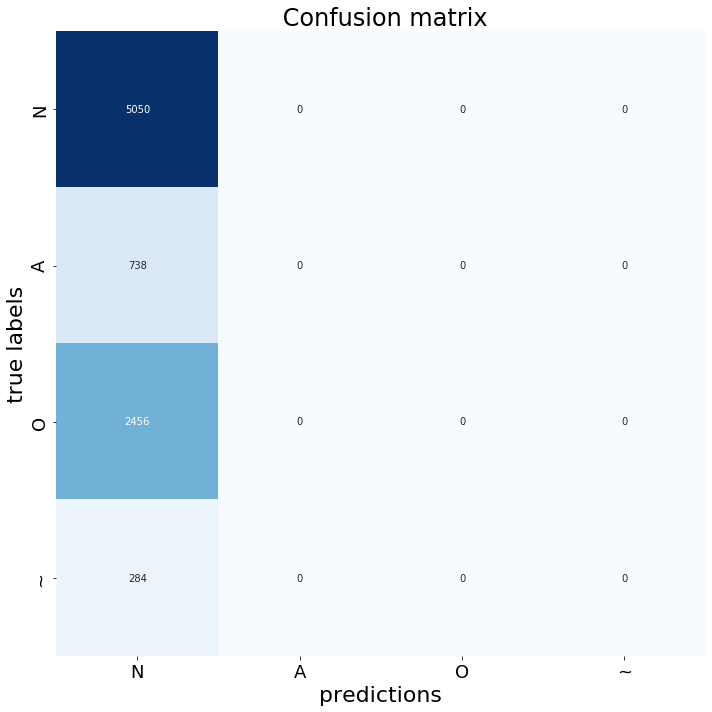

In [27]:
raw_model, \
raw_pred_train, \
raw_accuracy = train_model(n_features=sample_size, n_channels=1, x_train=x_train,
           y_train=y_train, n_epochs=20)

# Let's Create and Evaluate Features 

Now the that the data and model are defined, we can start creating features to better evaluate the data, reduce dimension, and possibly find better input combinations for our model. 

## Let's Start with the  FFT Features 

We first leverage the function we defined previously, in order to create an FFT dataset. This will be used to evaluate the performance of the fft alone. Eventually, we can also use it to compose a dataset with all features. 

In [28]:
fft_train_data = get_fft(data=train_data, absolute_value=True)

In [29]:
fft_train_data.shape

(20410, 4500)

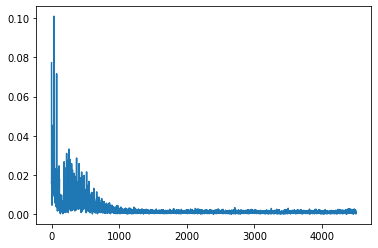

In [30]:
plt.plot(fft_train_data[1,:])
plt.show()

Let's choose the dimension based on where most of the information is located.

In [31]:
dimension_size = 1000

In [32]:
x_train = torch.tensor(fft_train_data[:,:dimension_size]).float().unsqueeze(1)
y_train = torch.tensor(labels_train).long()
x_train.shape

torch.Size([20410, 1, 1000])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3264       0.4169        1.2844  1.3189
      2        1.2362       0.5396        1.1870  1.2893
      3        1.1742       0.5790        1.1490  1.2724
      4        1.1487       0.5998        1.1265  1.3279
      5        1.1247       0.6182        1.1120  1.3592
      6        1.1070       0.6184        1.1138  1.3300
      7        1.0942       0.6211        1.1083  1.3159
      8        1.0810       0.6796        1.0567  1.3183
      9        1.0664       0.6887        1.0510  1.3406
     10        1.0501       0.6593        1.0754  1.5730
     11        1.0407       0.6997        1.0364  1.3256
     12        1.0402       0.6990        1.0404  1.3438
     13        1.0255       0.7166        1.0240  1.3438
     14        1.0150       0.7387        1.0022  1.3157
     15        1.0154       0.7218        1.0163  1.3308
     16        1.0087       0.7

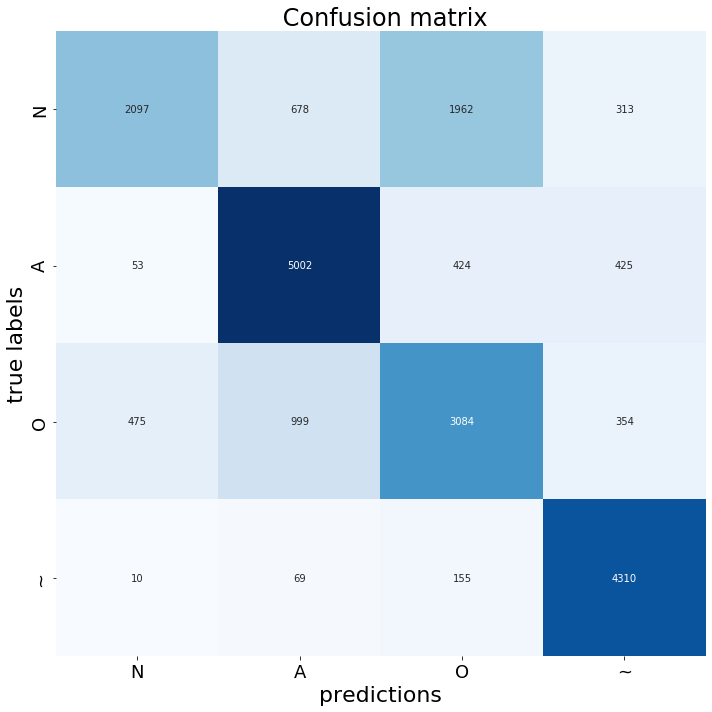

In [33]:
fft_model, \
fft_pred_train, \
fft_accuracy = train_model(n_features=dimension_size, n_channels=1, x_train=x_train,
           y_train=y_train, n_epochs=20)

## Get PCA Features from the Data

Since PCA takes a bit longer to compute, I have already computed and saved the results. However, it should be noted that I am not using a conventional covariance matrix estimator. I am using an estimator which Ledoit and Wolf proposed in 2004. 

In [34]:
eigen_values = np.load(data_dir + 'eigen_values_train_data.npy')
eigen_vectors = np.load(data_dir + 'eigen_vectors_train_data.npy')

In [35]:
eigen_values[:dimension_size]

array([265.99067662, 233.12093062, 224.58136642, 216.98789508,
       207.89369565, 197.99583933, 194.31305368, 185.24048371,
       175.9470432 , 164.90702642, 162.48099954, 156.0084501 ,
       152.56264761, 148.11207552, 138.75272835, 137.2488755 ,
       134.28607368, 127.47430857, 123.91734177, 120.40903987,
       116.92804975, 115.21266283, 111.67552273, 108.63073822,
       105.35443608, 102.56002802, 100.80476209,  98.57483985,
        94.0839849 ,  92.77847091,  91.7200277 ,  89.34395537,
        87.6102854 ,  86.58681695,  85.54485854,  83.02607182,
        82.36399179,  81.21259923,  78.80992329,  77.07841767,
        76.17337733,  74.30752101,  70.63265056,  69.77396145,
        68.49291836,  67.31110986,  66.46066344,  65.37077389,
        63.50297544,  62.62109491,  61.61133031,  58.62286958,
        58.12006415,  57.21176811,  55.95512539,  55.6774056 ,
        55.27750717,  54.31227912,  53.42848673,  52.63831566,
        50.99019528,  50.06353971,  49.64878393,  49.05

In [36]:
pca_train_data = train_data.dot(eigen_vectors[:,:dimension_size])
pca_train_data.shape

(20410, 1000)

torch.Size([20410, 1, 1000])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1516       0.6387        1.0890  1.4004
      2        1.0655       0.6970        1.0433  1.3644
      3        1.0170       0.7392        1.0045  1.3342
      4        0.9707       0.7014        1.0329  1.2937
      5        0.9423       0.7512        0.9923  1.3153
      6        0.9138       0.7864        0.9549  1.3146
      7        0.8998       0.8028        0.9415  1.2848
      8        0.8863       0.7979        0.9445  1.3174
      9        0.8742       0.7952        0.9461  1.3078
     10        0.8694       0.7886        0.9541  1.2945
     11        0.8630       0.8070        0.9342  1.3215
     12        0.8574       0.8104        0.9319  1.2915
     13        0.8517       0.7989        0.9422  1.3207
     14        0.8475       0.8119        0.9301  1.3511
     15        0.8402       0.8041        0.9375  1.6386
  

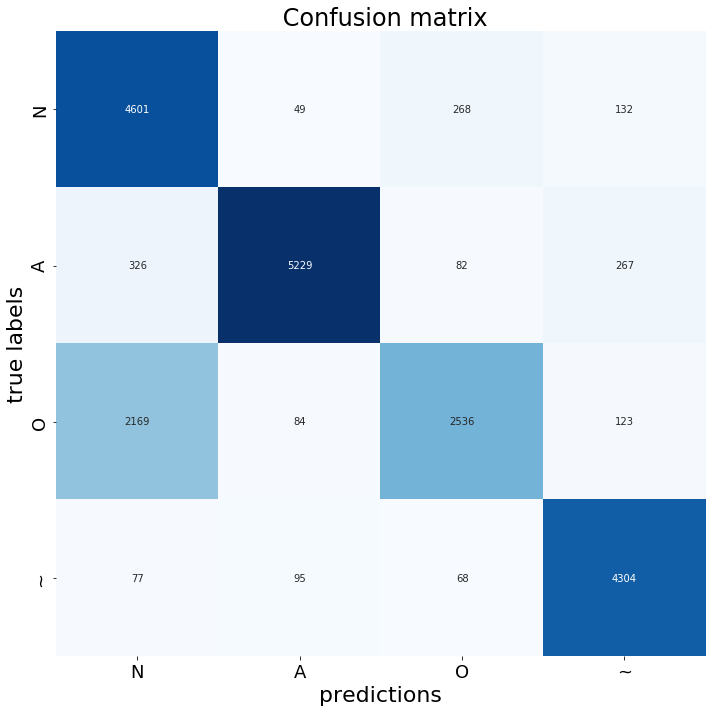

In [37]:
x_train = torch.tensor(pca_train_data).float().unsqueeze(1)
print(x_train.shape)
pca_model, \
pca_pred_train, \
pca_accuracy = train_model(n_features=dimension_size, n_channels=1, x_train=x_train,
           y_train=y_train, n_epochs=20)

## Get Statistical Features

In [38]:
stat_train_data = np.zeros([train_data.shape[0], 5])
stat_train_data[:, 0] += np.max(train_data, axis=1)
stat_train_data[:, 1] += np.min(train_data, axis=1)
stat_train_data[:, 2] += np.mean(train_data, axis=1)
stat_train_data[:, 3] += np.median(train_data, axis=1)
stat_train_data[:, 4] += np.std(train_data, axis=1)
stat_train_data.shape

(20410, 5)

In [39]:
stat_train_data[0]

array([ 3.85051408, -2.08242993, -0.00409358, -0.10331411,  0.67377406])

## Build Input Data with Concatenated Features

Here, we concatenate the features, in order to produce an input dataset that contains the all features

In [40]:
train_input_dimension = dimension_size\
                        + dimension_size\
                        + stat_train_data.shape[1]
all_feature_train_data = np.zeros([train_data.shape[0], train_input_dimension])

In [41]:
all_feature_train_data[:,:stat_train_data.shape[1]] += stat_train_data
all_feature_train_data[:,stat_train_data.shape[1]:stat_train_data.shape[1]\
                       + dimension_size] += pca_train_data
all_feature_train_data[:,stat_train_data.shape[1]\
                       + dimension_size:stat_train_data.shape[1]\
                       + 2 * dimension_size] += fft_train_data[:,:dimension_size]

torch.Size([20410, 1, 2005])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1798       0.6253        1.1157  1.8833
      2        1.1112       0.6397        1.0990  1.7774
      3        1.0798       0.6642        1.0756  1.7755
      4        1.0601       0.6838        1.0613  1.8090
      5        1.0396       0.7032        1.0407  1.9745
      6        1.0034       0.7110        1.0220  1.7828
      7        0.9665       0.7686        0.9681  1.7780
      8        0.9346       0.7612        0.9771  1.7740
      9        0.9104       0.7815        0.9608  1.7777
     10        0.8919       0.7558        0.9821  1.7672
     11        0.8755       0.8043        0.9378  1.7805
     12        0.8651       0.8014        0.9407  1.7893
     13        0.8579       0.8117        0.9316  1.7721
     14        0.8537       0.8085        0.9324  1.7783
     15        0.8569       0.7979        0.9443  1.7919
  

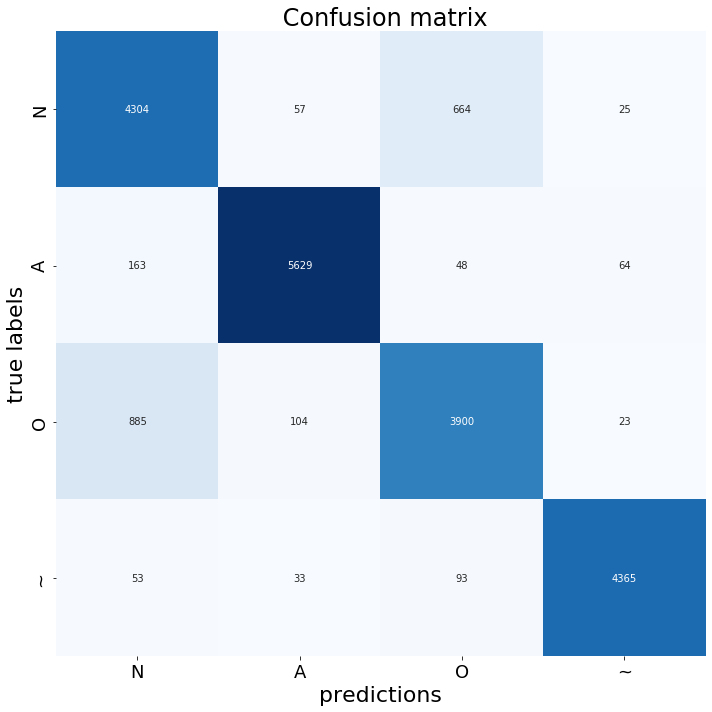

In [42]:
x_train = torch.tensor(all_feature_train_data).float().unsqueeze(1)
print(x_train.shape)
all_feature_model, \
all_feature_pred_train, \
all_feature_accuracy = train_model(n_features=train_input_dimension, 
                                   n_channels=1, x_train=x_train,
           y_train=y_train, n_epochs=20)

## Verifying Feature Correlations

Now, we evaluate the feature correlations in order to further reduce our dimensions, and hopefully achieve a better performance

In [43]:
correlations = np.corrcoef(all_feature_train_data, rowvar=False)
correlations

array([[ 1.        , -0.57812283,  0.26576343, ...,  0.31519819,
         0.32510645,  0.28757792],
       [-0.57812283,  1.        ,  0.24205664, ..., -0.33641209,
        -0.32415074, -0.30867148],
       [ 0.26576343,  0.24205664,  1.        , ..., -0.01806527,
         0.00146444, -0.02408022],
       ...,
       [ 0.31519819, -0.33641209, -0.01806527, ...,  1.        ,
         0.56856036,  0.54996412],
       [ 0.32510645, -0.32415074,  0.00146444, ...,  0.56856036,
         1.        ,  0.60480487],
       [ 0.28757792, -0.30867148, -0.02408022, ...,  0.54996412,
         0.60480487,  1.        ]])

In [44]:
abs_correlations = np.abs(correlations)
mean_corr = abs_correlations.mean(axis=1)
print("mean: {}".format(mean_corr))
min_corr = abs_correlations.min(axis=1)
print("min: {}".format(min_corr))
median_corr = np.median(abs_correlations, axis=1)
print("median: {}".format(median_corr))

mean: [0.18623086 0.17793586 0.02733775 ... 0.20211484 0.19720213 0.19724352]
min: [3.66359703e-06 2.69406753e-05 8.27868949e-07 ... 1.78196049e-05
 1.96209896e-05 7.51326545e-06]
median: [0.21177109 0.19751608 0.00859909 ... 0.13430407 0.14951895 0.1375586 ]


In [45]:
chosen_features = np.where(mean_corr <=0.01)
number_of_chosen_features = len(chosen_features[0])
print(number_of_chosen_features)


791


## Training with Least Correlated Features

torch.Size([20410, 1, 791])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1843       0.6143        1.1224  1.8490
      2        1.1030       0.6556        1.0866  1.7838
      3        1.0638       0.6774        1.0682  1.7905
      4        1.0403       0.7010        1.0405  1.7848
      5        1.0097       0.7370        1.0037  1.7852
      6        0.9712       0.7365        0.9999  1.7918
      7        0.9439       0.7717        0.9687  1.7889
      8        0.9178       0.7774        0.9630  1.7998
      9        0.9013       0.7142        1.0242  1.7926
     10        0.8916       0.7820        0.9575  1.7912
     11        0.8770       0.7869        0.9523  1.9307
     12        0.8750       0.7641        0.9767  1.8473
     13        0.8639       0.7962        0.9435  1.7879
     14        0.8581       0.7982        0.9423  1.7880
     15        0.8567       0.7977        0.9444  1.8365
   

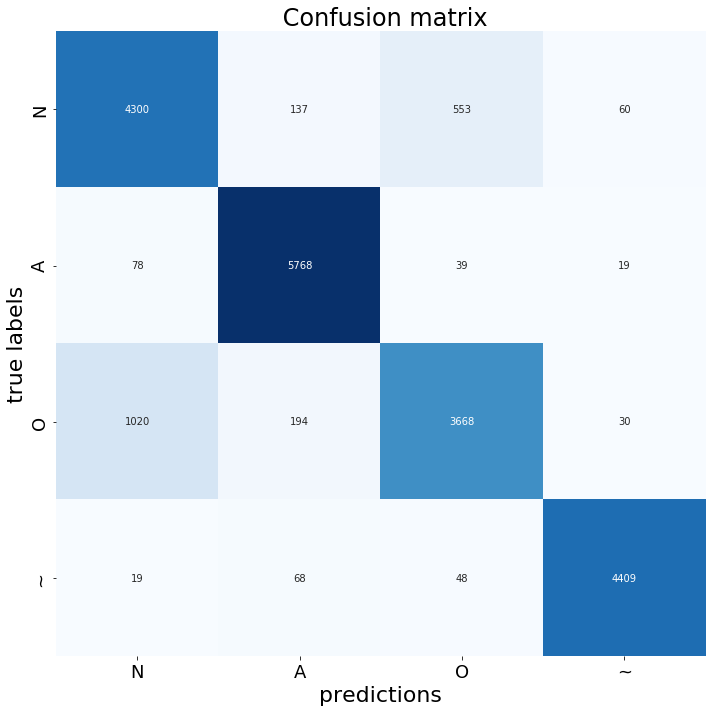

In [46]:
x_train = torch.tensor(all_feature_train_data[:, chosen_features]).float()
print(x_train.shape)
chosen_feature_model, \
chosen_feature_pred_train, \
chosen_feature_accuracy = train_model(n_features=number_of_chosen_features, 
                                   n_channels=1, x_train=x_train,
           y_train=y_train, n_epochs=20)

## Conclusion
* We have seen how to produce different types of features: FFT, PCA, and Stats
* Pytorch, Scorch, and SKLearn used for Deep Learning
* The Value of selecting the less correlated features
* Questions ?! 